In [78]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
# read in all the words 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [80]:
len(words)

32033

In [81]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [82]:
#build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [83]:
# # MLP revisited
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 200 # the number of neurons ini the hidden layer of the mlp

# g = torch.Generator().manual_seed(2147483647) # for reproducibility 
# C = torch.randn((vocab_size, n_embd), generator=g)
# W1 = torch.rand((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.02
# W2 = torch.rand((n_hidden, vocab_size), generator=g) * 0.02
# b2 = torch.randn(vocab_size, generator=g) * 0 

# # Batch norm parameters
# bngain = torch.ones((1, n_hidden))
# bnbias = torch.zeros((1, n_hidden))
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
# print(sum(p.nelement() for p in parameters)) # number of parameters in total 
# for p in parameters:
#     p.requires_grad = True

In [92]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.randn(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters to learn with backprop
        self.gamma = torch.ones((1, dim))
        self.beta = torch.zeros((1, dim))
        #buffers (learned with a running 'momentum' update)
        self.running_mean = torch.zeros((1, dim))
        self.running_var = torch.ones((1, dim))
        
    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean 
            xvar = x.var(0, keepdim=True, unbiased=True) #batch variance
        else: 
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta #scale and shift
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons ini the hidden layer of the mlp
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]
    
with torch.no_grad():
    # last layer is special, we want the init to be small - less confident 
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.01
    # all other layers apply gain 
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= (5/3)
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

37251


In [93]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    #forward pass
    emb = C[Xb] # embedd the charaters into vectors
    x = emb.view(emb.shape[0], -1) # concat the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # compute the loss

    #backward pass
    for layer in layers:
        layer.out.retain_grad() # make sure we retain the gradients for all intermediate layers
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay 
    for p in parameters: 
        p.data += -lr * p.grad
        
    # track stats 
    if i % 10000 == 0: #  print every once in a while 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    

      0/ 200000: 3.2947
  10000/ 200000: 2.3396
  20000/ 200000: 1.9485
  30000/ 200000: 1.9525
  40000/ 200000: 2.3808
  50000/ 200000: 2.3344
  60000/ 200000: 1.8484
  70000/ 200000: 2.1318
  80000/ 200000: 2.1431
  90000/ 200000: 1.8343
 100000/ 200000: 1.7177
 110000/ 200000: 2.0723
 120000/ 200000: 1.7635
 130000/ 200000: 1.8276
 140000/ 200000: 2.1045
 150000/ 200000: 1.9187
 160000/ 200000: 1.9968
 170000/ 200000: 2.2683
 180000/ 200000: 2.0563
 190000/ 200000: 1.9539


layer 2 (      Tanh): mean -0.01 std +0.71 saturated: 7.00%
layer 5 (      Tanh): mean -0.00 std +0.75 saturated: 8.78%
layer 8 (      Tanh): mean +0.00 std +0.77 saturated: 9.44%
layer 11 (      Tanh): mean -0.03 std +0.79 saturated: 10.84%


Text(0.5, 1.0, 'Histogram of activations')

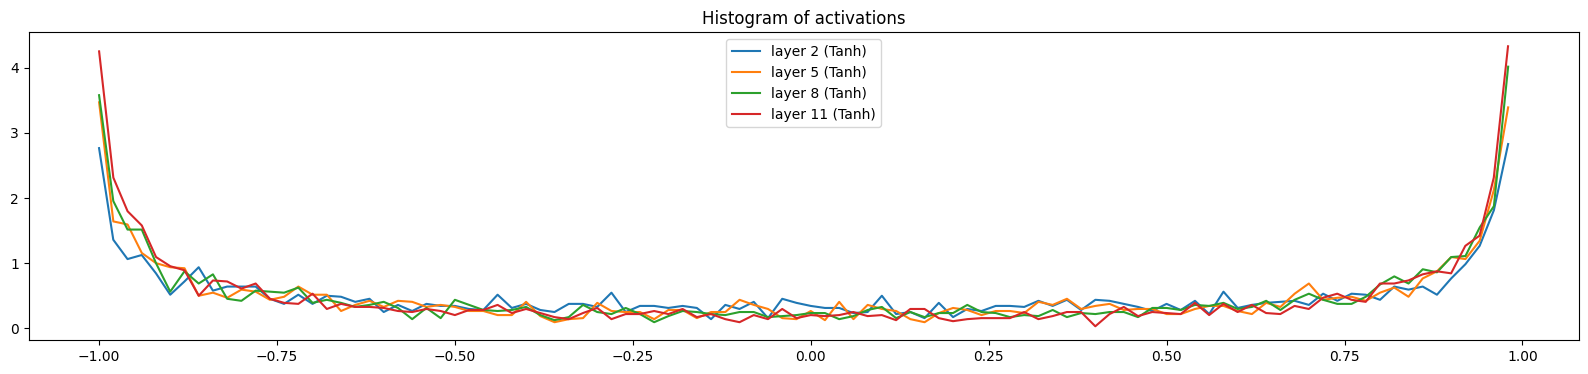

In [94]:
# visualization 

plt.figure(figsize=(20, 4)) # w and h of the plot
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        saturated = (t.abs() > 0.99).float().mean() * 100
        print('layer %d (%10s): mean %+.2f std %+.2f saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean().item(), t.std().item(), saturated.item()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title("Histogram of activations")

layer 0 (    Linear): mean -0.00 std +0.00
layer 3 (    Linear): mean +0.00 std +0.00
layer 6 (    Linear): mean -0.00 std +0.00
layer 9 (    Linear): mean +0.00 std +0.00
layer 12 (    Linear): mean -0.00 std +0.00


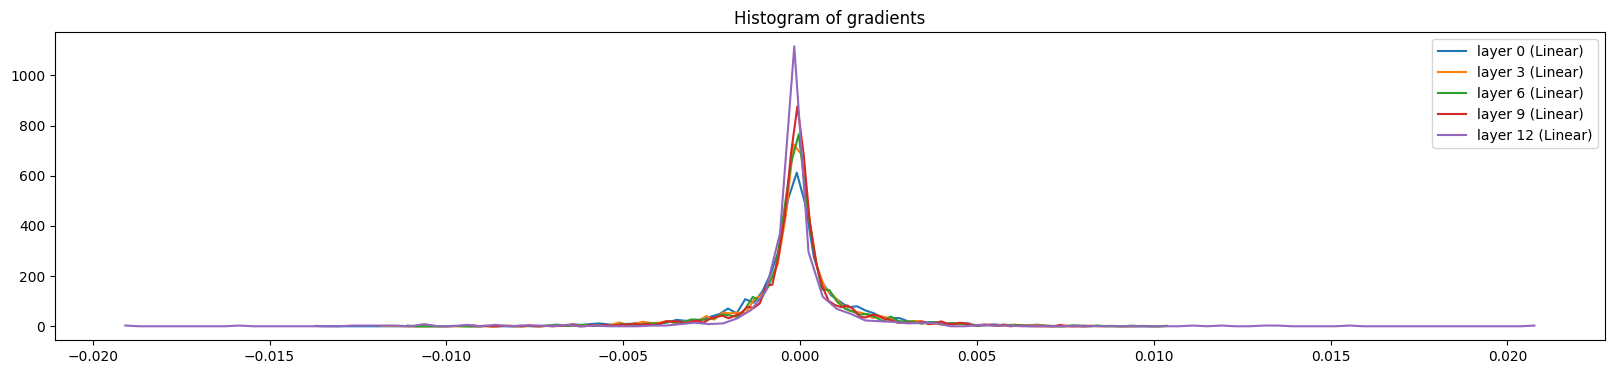

In [95]:
# visualization histograms 
plt.figure(figsize=(20, 4)) # w and h of the plot
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Linear):
        g = layer.out.grad
        print('layer %d (%10s): mean %+.2f std %+.2f' % (i, layer.__class__.__name__, g.mean().item(), g.std().item()))
        hy, hx = torch.histogram(g, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("Histogram of gradients");

weights   (27, 10) | mean +0.000000 | std 1.502055e-02 | grad:data ratio 1.366150e-02
weights  (30, 100) | mean -0.000039 | std 9.497296e-03 | grad:data ratio 2.319125e-02
weights   (1, 100) | mean -0.000208 | std 4.884746e-03 | grad:data ratio 3.458661e-02
weights   (1, 100) | mean -0.000213 | std 8.145582e-03 | grad:data ratio 2.389980e-02
weights (100, 100) | mean -0.000027 | std 6.498640e-03 | grad:data ratio 2.574826e-02
weights   (1, 100) | mean +0.000341 | std 4.827617e-03 | grad:data ratio 3.757555e-02
weights   (1, 100) | mean -0.000467 | std 8.333118e-03 | grad:data ratio 2.579772e-02
weights (100, 100) | mean +0.000069 | std 6.661701e-03 | grad:data ratio 2.685301e-02
weights   (1, 100) | mean +0.000140 | std 4.413434e-03 | grad:data ratio 3.135139e-02
weights   (1, 100) | mean -0.000013 | std 8.428371e-03 | grad:data ratio 2.476186e-02
weights (100, 100) | mean -0.000023 | std 5.962015e-03 | grad:data ratio 2.491186e-02
weights   (1, 100) | mean +0.000418 | std 3.556276e-03

Text(0.5, 1.0, 'weight gradient distribution')

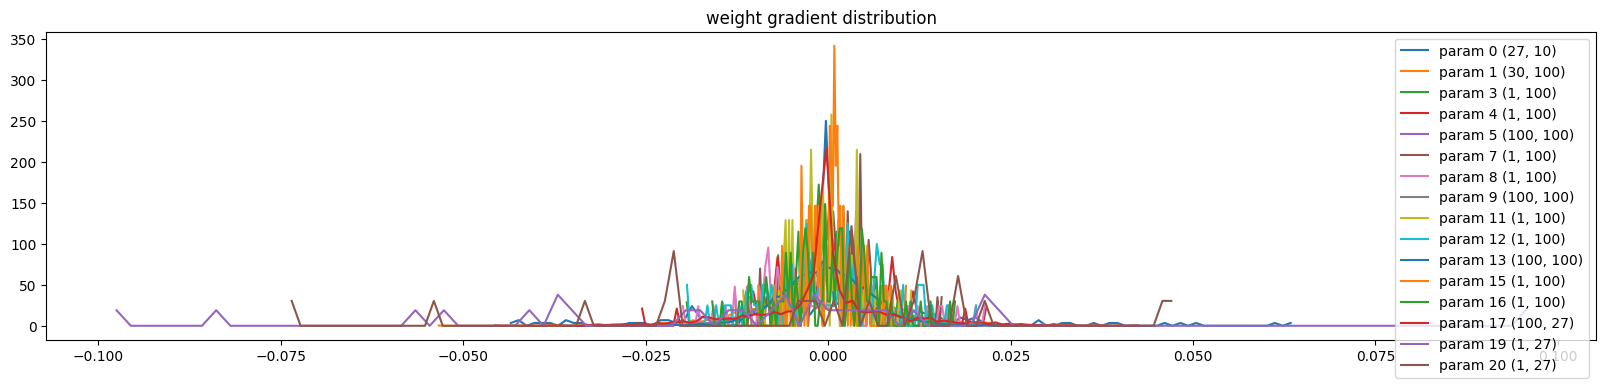

In [96]:
# visualize histograms
plt.figure(figsize=(20, 4)) # w and h of the plot
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:

        print('weights %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean().item(), t.std().item(), (t.std()/p.std()).item()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'param {i} {tuple(p.shape)}')
        
plt.legend(legends);
plt.title('weight gradient distribution')

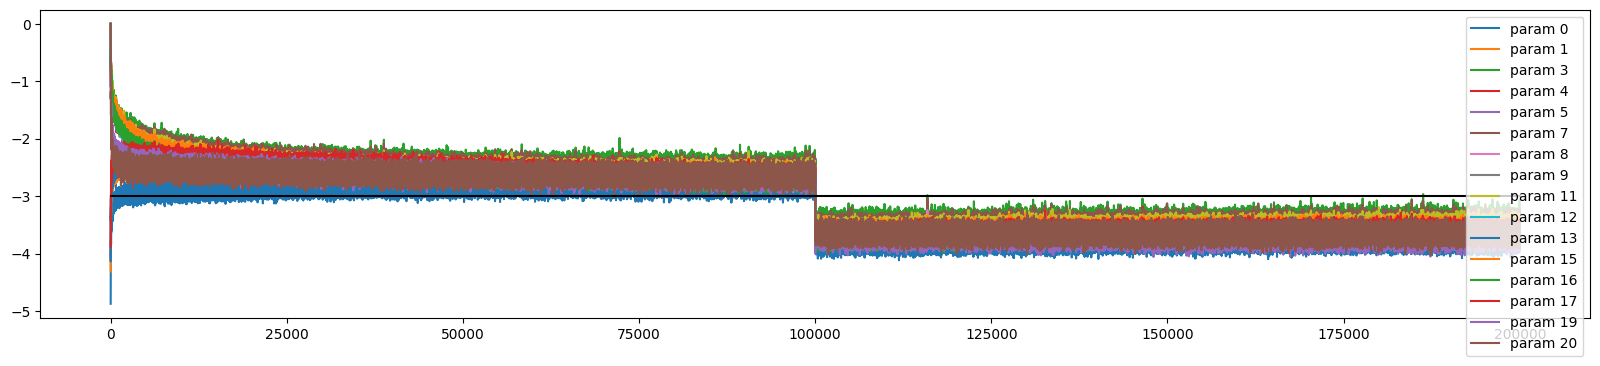

In [97]:
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d' % i)
    
plt.plot([0, len(ud)], [-3, -3], 'k') # these rations should be ~1e-3, indicate on plot
plt.legend(legends)

In [98]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xva, Yva),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1)  # Flatten to (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())
    
# put layers into eval mode 

for layer in layers:
    layer.training = False

split_loss('train')
split_loss('val')

train 2.02181339263916
val 2.0907697677612305


In [99]:
# sample from the model 

g = torch.Generator().manual_seed(2147483647)

for _ in range(20): 
    
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        x = emb.view(1, -1)  # (1, block_size * n_embd)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from distribution 
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break 
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

dex.
mariah.
makima.
kayden.
mairitta.
noluwak.
katar.
samiyah.
jaxson.
mari.
moriellah.
jackteda.
kaley.
massie.
enkavion.
zakis.
mhithven.
tahlan.
kashra.
antil.
